# Identify tags in airline database

## Minimal code

    - Read dataset
    - transform data
    - Minimal model
        - Embedings
        - Dense
        


In [3]:
from __future__ import print_function

import os 
import numpy as np 

import tensorflow as tf 
print(tf.__version__)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 

1.3.0


## Dataset

ATIS (Airline Travel Information System) dataset. Available in: https://github.com/mesnilgr/is13/blob/master/data/load.py

### Example:

Input (words)	show	flights	from	Boston	to	New	York	today

Output (labels)	O	O	O	B-dept	O	B-arr	I-arr	B-date




In [4]:
# Read data
import pickle
import sys

atis_file = '/Users/jorge/data/training/text/atis/atis.pkl'
#atis_file = '/home/ubuntu/data/training/text/atis/atis.pkl'

with open(atis_file,'rb') as f:
    if sys.version_info.major==2:
        train, test, dicts = pickle.load(f) #python2.7
    else:
        train, test, dicts = pickle.load(f, encoding='bytes') #python3


## train / test sets:
    - X: list of input sequences
    - label: List of target labels asociated to each word in each sentence.
## Dictionaries
    - labels2idx:  To decode the labels
    - words2idx: To decode the sentences

In [5]:
#Dictionaries and train test partition
w2idx = dict()
for i in dicts[b'words2idx']:
    w2idx[i.decode("utf-8")] = dicts[b'words2idx'][i]

ne2idx = dict()
for i in dicts[b'tables2idx']:
    ne2idx[i.decode("utf-8")] = dicts[b'tables2idx'][i]

labels2idx = dict()
for i in dicts[b'labels2idx']:
    labels2idx[i.decode("utf-8")] = dicts[b'labels2idx'][i]
    
idx2w  = dict((v,k) for k,v in w2idx.items())
idx2la = dict((v,k) for k,v in labels2idx.items())

train_x, _, train_label = train
test_x,  _,  test_label  = test



# Visualize data
wlength = 35
for e in ['train','test']:
    print(e)
    for sw, sl in zip(eval(e+'_x')[:2], eval(e+'_label')[:2]):
        print( 'WORD'.rjust(wlength), 'LABEL'.rjust(wlength))
        for wx, la in zip(sw, sl): print( idx2w[wx].rjust(wlength), idx2la[la].rjust(wlength))
        print( '\n'+'**'*30+'\n')


train
                               WORD                               LABEL
                                  i                                   O
                               want                                   O
                                 to                                   O
                                fly                                   O
                               from                                   O
                             boston                 B-fromloc.city_name
                                 at                                   O
                    DIGITDIGITDIGIT                  B-depart_time.time
                                 am                  I-depart_time.time
                                and                                   O
                             arrive                                   O
                                 in                                   O
                             denver                   B-to

In [6]:
#Select words for the label 48: b'B-fromloc.city_name' in train and test to check that are different:
for e in ['train','test']:
    print(e)
    print('---------')
    for sw, sl in zip(eval(e+'_x')[:5], eval(e+'_label')[:5]):
        for wx, la in zip(sw, sl): 
            if la==48:
                print( idx2w[wx])
    print('\n')


train
---------
boston
pittsburgh
san
washington
tacoma
pittsburgh


test
---------
charlotte
tacoma
phoenix
phoenix
orlando




## Data transformation
    - Convert the list of sequences of words into an array of words x characteristics.
    - The characteristics are the context of the word in the sentence.
        - For each word in the sentence, generate the context with the previous and the next words in the sentence.
        - For words at the beggining and the end, use padding to complete the context.

In [7]:
# Max value of word coding to assign the ID_PAD
ID_PAD = np.max([np.max(tx) for tx in train_x]) + 1
print('ID_PAD: ', ID_PAD)

def context(l, size=3):
    l = list(l)
    lpadded = size // 2 * [ID_PAD] + l + size // 2 * [ID_PAD]
    out = [lpadded[i:(i + size)] for i in range(len(l))]
    return out

#Example
x = np.array([0, 1, 2, 3, 4], dtype=np.int32)
print('Context vectors: ', context(x))

ID_PAD:  572
Context vectors:  [[572, 0, 1], [0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 572]]


In [8]:
# Create train and test X y.
X_trn=[]
for s in train_x:
    X_trn += context(s,size=10)
X_trn = np.array(X_trn)

X_tst=[]
for s in test_x:
    X_tst += context(s,size=10)
X_tst = np.array(X_tst)

print('X trn shape: ', X_trn.shape)
print('X_tst shape: ',X_tst.shape)


y_trn=[]
for s in train_label:
    y_trn += list(s)
y_trn = np.array(y_trn)
print('y_trn shape: ',y_trn.shape)

y_tst=[]
for s in test_label:
    y_tst += list(s)
y_tst = np.array(y_tst)
print('y_tst shape: ',y_tst.shape)


X trn shape:  (56590, 10)
X_tst shape:  (9198, 10)
y_trn shape:  (56590,)
y_tst shape:  (9198,)


In [9]:
print('Num labels: ',len(set(y_trn)))
print('Num words: ',len(set(idx2w)))

Num labels:  121
Num words:  572


# First model

## Architecture
    - tf.nn.embedding_lookup
    - Dense layer: tf.nn.relu(tf.matmul(x, W) + b)
    

In [10]:
#General parameters
LOG_DIR = '/tmp/tensorboard/airline/embeddings/'

# data attributes
input_seq_length = X_trn.shape[1]
input_vocabulary_size = len(set(idx2w)) + 1
output_length = 127

#Model parameters
embedding_size=64


In [11]:
# build the model: Simple LSTM with embedings

from tensorflow.contrib.keras import layers, models, optimizers

print('Build model 1')
seq_input = layers.Input(shape=([input_seq_length]), name='prev') 
    
embeds = layers.Embedding(input_vocabulary_size, embedding_size)(seq_input)

flat_embeds = layers.Flatten()(embeds)
    
output = layers.Dense(output_length, activation='softmax')(flat_embeds)

model1 = models.Model(inputs=seq_input, outputs=output)
model1.summary()

# Optimizer
adam_optimizer = optimizers.Adam()
model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            36672     
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 127)               81407     
Total params: 118,079
Trainable params: 118,079
Non-trainable params: 0
_________________________________________________________________


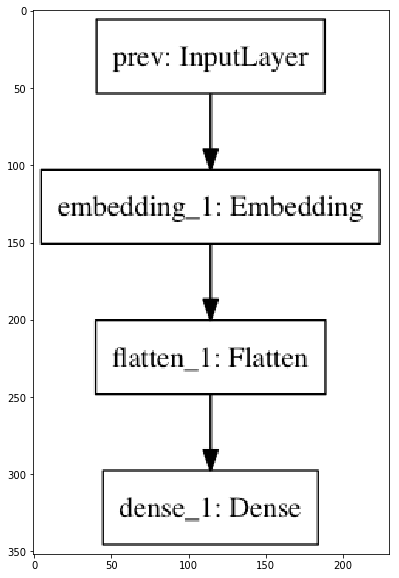

In [12]:
#Plot the model graph
from tensorflow.contrib.keras import utils

# Create model image
utils.plot_model(model1, '/tmp/model1.png')

# Show image
plt.imshow(plt.imread('/tmp/model1.png'))


In [13]:
#Fit model
from tensorflow.contrib.keras import callbacks

tb_callback = callbacks.TensorBoard(log_dir='/tmp/tensorboard/airline/embedings/')

history = model1.fit(X_trn, y_trn, batch_size=128, epochs=20,
           validation_data=(X_tst, y_tst), callbacks=[tb_callback])


Train on 56590 samples, validate on 9198 samples
Epoch 1/20
56590/56590 [==============================] - 1s - loss: 0.9447 - acc: 0.7931 - val_loss: 0.5795 - val_acc: 0.8656
Epoch 2/20
56590/56590 [==============================] - 1s - loss: 0.2789 - acc: 0.9345 - val_loss: 0.3072 - val_acc: 0.9301
Epoch 3/20
56590/56590 [==============================] - 1s - loss: 0.1347 - acc: 0.9687 - val_loss: 0.2222 - val_acc: 0.9515
Epoch 4/20
56590/56590 [==============================] - 1s - loss: 0.0826 - acc: 0.9813 - val_loss: 0.1790 - val_acc: 0.9608
Epoch 5/20
56590/56590 [==============================] - 1s - loss: 0.0576 - acc: 0.9866 - val_loss: 0.1642 - val_acc: 0.9653
Epoch 6/20
56590/56590 [==============================] - 1s - loss: 0.0420 - acc: 0.9901 - val_loss: 0.1493 - val_acc: 0.9685
Epoch 7/20
56590/56590 [==============================] - 1s - loss: 0.0318 - acc: 0.9925 - val_loss: 0.1518 - val_acc: 0.9713
Epoch 8/20
56590/56590 [==============================] - 1s -

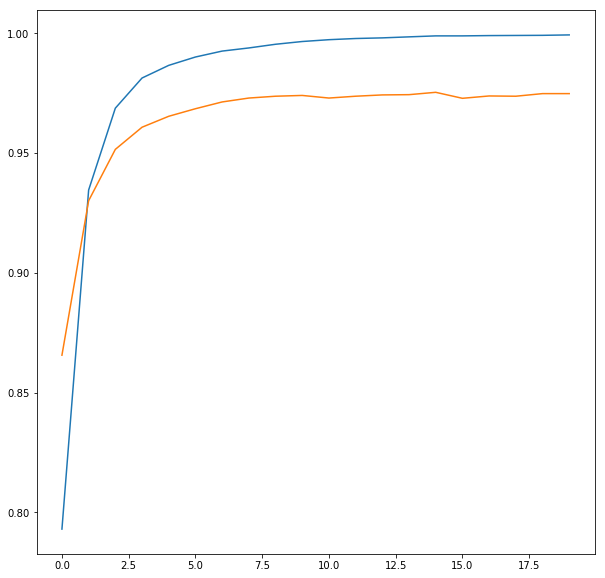

In [14]:
#Plot graphs in the notebook output
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [15]:
# Predict. Score new paragraph 
def score_paragraph(paragraph):
    #Preprocess data
    p_w = paragraph.split()
    p_w_c = [w2idx[w] for w in  p_w]
    x_score = np.array(context(p_w_c, size=10))
    
    # Score
    pred_score = model1.predict(x_score)
    response = [idx2la[l] for l in np.argmax(pred_score,axis=1)]
    
    return response


paragraph = 'i need a business ticket in any flight with departure from alaska to las vegas monday with breakfast'
response = score_paragraph(paragraph)
wlength = 35
for wx, la in zip(paragraph.split(), response): print( wx.rjust(wlength), la.rjust(wlength))


                                  i                                   O
                               need                                   O
                                  a                                   O
                           business                                   O
                             ticket                                   O
                                 in                                   O
                                any                                   O
                             flight                                   O
                               with                                   O
                          departure                                   O
                               from                                   O
                             alaska                 B-fromloc.city_name
                                 to                                   O
                                las                   B-toloc.ci